# Crowd counting in densely populated areas Platforms
### Independent Project by Hannah Halvorsen
### Computer Vision
### Harvard Extension School
### Spring 2024

# Introduction:

Crowd counting in densely populated areas poses a significant challenge for various sectors, including urban planning, event management, and public safety. Traditional methods of manual counting are not only labor-intensive and time-consuming but also prone to errors. In response to these challenges, this project focuses on developing regression-based methods to accurately estimate crowd density, with a specific emphasis on detecting individual heads within crowds.

# Problem Statement:

The primary objective of this project is to address the inherent difficulties associated with crowd counting in densely populated areas. By leveraging regression-based techniques, the aim is to automate the process of counting heads within crowds, thereby overcoming the limitations of manual counting methods. The ultimate goal is to provide stakeholders with a reliable and efficient solution for monitoring crowd density in real-time, enabling better decision-making and resource allocation.

# Value Proposition:

The project's significance lies in its potential to revolutionize crowd management and safety practices. By automating the crowd counting process, stakeholders such as urban planners, event organizers, and law enforcement agencies can benefit from improved efficiency, accuracy, and scalability. This, in turn, facilitates better-informed decision-making, optimal resource utilization, and enhanced safety measures in crowded environments. Ultimately, the project aims to contribute to the overall well-being and security of individuals in densely populated areas.

# Summary of results 

This project aimed to develop regression-based methods for crowd counting in densely populated areas, with a focus on detecting individual heads within crowds. Traditional manual counting methods are labor-intensive, time-consuming, and error-prone, necessitating automated solutions.

Two deep learning models were explored: the Age Predictor Model based on AlexNet architecture and the Vgg16 Model (CrowdCounting) based on VGG16 architecture. Both models underwent training and validation processes, with Mean Squared Error (MSE) used as the optimization criterion.

Upon evaluation on the test set, the Vgg16-based CrowdCounting model outperformed the Age Predictor model, achieving lower Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) metrics. However, both models exhibited limitations, with relatively high errors in their predictions.

# Framework for Crowd Counting Project

### 1. Data Preparation (make_txt function):

This step involves preparing text files containing the file names of images for training and validation. The make_txt function shuffles the list of image files and then splits them into training and validation sets based on the specified validation size.

### 2. Custom Dataset Class (CustomDataset):

The CustomDataset class defines a custom dataset for loading images and their corresponding crowd count labels. It loads images from the specified directory based on the dataset type ('train', 'val', or 'test') and reads the ground truth crowd counts from corresponding MAT files.

### 3. Visualize Images with Head Count (show_batch_images):

This function is designed to visualize a batch of images along with their corresponding ground truth counts using Matplotlib. It provides a visual understanding of the data distribution and the associated crowd counts.

### 4. Data Loading and Transformation (new_transforms, new_dataset, new_dataloader):

Image transformations are defined using torchvision.transforms.Compose. The new_transforms function prepares the necessary transformations for data augmentation and preprocessing. The new_dataset function instantiates the dataset using the CustomDataset class, specifying the root directory and dataset type. Data is then loaded into batches using the new_dataloader function.

### 5. Age Predictor Model (AgePredictor) and Vgg16 Model (CrowdCounting):

The AgePredictor class defines a neural network model for predicting crowd counts using transfer learning from the AlexNet architecture. The forward method within the class defines the forward pass of the network, which takes input images and produces crowd count predictions.

The Vgg16 class defines a neural network model for predicting crowd counts using transfer learning from the vgg16 architecture. The forward method defines the forward pass of the network.

### 6. Training and Validation (train_model, validate_model):

Functions for training and validation are crucial steps in the pipeline. The train_model function trains the model using the training data loader, while the validate_model function evaluates the model using the validation data loader. These functions monitor the model's performance and adjust its parameters accordingly.

### 7. Model Evaluation (evaluate_model, visualize_predictions):

Finally, we have functions for evaluating the trained model on the test set and visualizing predictions. The evaluate_model function computes the RMSE and MAE metrics on the test set, providing insights into the model's performance. The visualize_predictions function shows a comparison between actual and predicted crowd counts for a few images from the test set, offering a qualitative assessment of the model's accuracy.

# Data Preparation (make_txt function): 
This function prepares text files containing the file names of images for training and validation. It shuffles the list of image files and then splits them into training and validation sets based on the specified validation size. The file names are then saved as text files (train.txt and val.txt) in a directory named make_txt.

In [43]:
import os
import random

def make_txt(new_root_dir, val_size=0.1):
    img_files = [f for f in os.listdir(new_root_dir) if os.path.isfile(os.path.join(new_root_dir, f))]
    # Shuffle the list of files
    random.shuffle(img_files)
    
    # Calculate the split index
    total_img = len(img_files)
    val_split_idx = int(total_img * (1 - val_size))
    
    # Split the dataset
    train_files = img_files[:val_split_idx]
    val_files = img_files[val_split_idx:]
    
    write_dir = './make_txt'
    os.makedirs(write_dir, exist_ok=True)
    # Save as TXT files
    with open(os.path.join(write_dir, 'train.txt'), 'w') as f:
        f.write('\n'.join(train_files))
    with open(os.path.join(write_dir, 'val.txt'), 'w') as f:
        f.write('\n'.join(val_files))

random.seed(42)
make_txt('/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images')

# Custom Dataset Class (CustomDataset): 
This class defines a custom dataset for loading images and their corresponding crowd count labels. It inherits from PyTorch's Dataset class and implements the __len__ and __getitem__ methods to support indexing and length querying. It loads images from the specified directory (new_root_dir) based on the dataset type ('train', 'val', or 'test'). It also reads the ground truth crowd counts from corresponding MAT files.

In [44]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import to_grayscale

class CustomDataset(Dataset):
    def __init__(self, new_root_dir, dataset_type='train', transform=None):
        """
        Args:
            new_root_dir (string): Path to the directory containing image files.
            dataset_type (string): Type of dataset ('train', 'val', 'test').
            transform (callable, optional): Optional image transform to be applied.
        """
        if dataset_type == 'train' or dataset_type == 'val':
            new_root_dir = os.path.join(new_root_dir, 'train_data')
            self.image_dir = os.path.join(new_root_dir, 'images')
            txt_file_path = os.path.join('./make_txt', dataset_type+'.txt')
            with open(txt_file_path, 'r') as file:
                self.image_files = file.read().splitlines()
        else:
            new_root_dir = os.path.join(new_root_dir, dataset_type+'_data')
            self.image_dir = os.path.join(new_root_dir, 'images')
            self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]        
        
        self.gt_dir = os.path.join(new_root_dir, 'ground-truth')
        self.transform = transform

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, self.image_files[idx]))
        
        gt_name = os.path.join(self.gt_dir, 'GT_' + self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = loadmat(gt_name)
        number = gt_data['image_info'][0][0][0][0][1][0][0]  # Get the count
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(number, dtype=torch.float)

# Visualize images with head count (show_batch_images)
Function that visualizes a batch of images along with their corresponding ground truth counts. It takes a PyTorch DataLoader object as input, extracts a batch of images and their counts, and then displays each image with its count above it using Matplotlib.

In [45]:
import matplotlib.pyplot as plt

def show_batch_images(new_dataloader):
    """
    Show a batch of images and their ground truths from a DataLoader.

    Args:
        new_dataloader (DataLoader): PyTorch DataLoader object.
    """
    # Get a batch of data
    images, numbers = next(iter(new_dataloader))
    
    # Set the image size
    plt.figure(figsize=(6, 10))
    
    # Get the batch size to determine the number of images per row
    batch_size = len(images)
    
    # Iterate over each image in the batch
    for idx in range(batch_size):
        ax = plt.subplot(1, len(images), idx+1)
        img = images[idx].numpy().transpose((1, 2, 0))
        plt.imshow(img)        
        # Display the ground truth count above the image
        plt.title(f'Count: {numbers[idx].item()}')
        plt.axis('off')
    
    plt.show()

# Data Loading and Transformation (new_transforms, new_dataset, new_dataloader):
Image transformations are defined using torchvision.transforms.Compose, which combines several image transformations together. The dataset is instantiated using the CustomDataset class, specifying the root directory and dataset type. 

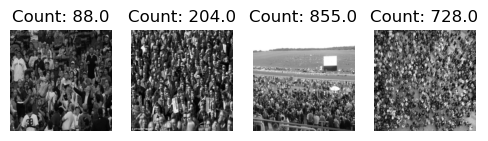

In [46]:
from torchvision.transforms import Resize, Grayscale, ToTensor, Compose

# Define the image transformation pipeline
new_transforms = Compose([
    Grayscale(num_output_channels=3),  
    Resize((224, 224)),  # Resize the image
    ToTensor(),  # Convert the image to a PyTorch tensor
])

new_dataset = CustomDataset(new_root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                            dataset_type='train',
                            transform=new_transforms)

# Load data using DataLoader
new_dataloader = DataLoader(new_dataset, batch_size=4, shuffle=True)

# Test DataLoader
show_batch_images(new_dataloader)

# Age Predictor Model (AgePredictor): 
This class defines a neural network model for predicting crowd counts using transfer learning from the AlexNet architecture. The forward method defines the forward pass of the network.

In [47]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class AgePredictor(nn.Module):
    def __init__(self):
        super(AgePredictor, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        
        for param in alexnet.parameters():
            param.requires_grad = False
        # Use the feature extraction part of AlexNet
        self.features = alexnet.features
        
        # Replace the classifier part of AlexNet for age regression task
        self.regressor = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),  # Adjust based on the dimensions of AlexNet features
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x


# Prepare data loaders for training, validation, and testing
by creating datasets with custom transformations and loading them into batches using DataLoader.

In [48]:
train_dataset = CustomDataset(new_root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                              dataset_type='train',
                              transform=new_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                               
val_dataset = CustomDataset(new_root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                            dataset_type='val',
                            transform=new_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(new_root_dir='/Users/hannah/Downloads/ShanghaiTech_Crowd_Counting_Dataset/part_A_final',
                             dataset_type='test',
                             transform=new_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Training and Validation (train_model, validate_model): 
Functions for training and validation are defined. The train_model function trains the model using the training data loader, while the validate_model function evaluates the model using the validation data loader.

In [49]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('runs/age_prediction_experiment')

def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for inputs, ages in train_loader:
        inputs, ages = inputs.to(device), ages.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, ages.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    return avg_loss

def validate_model(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, ages in val_loader:
            inputs, ages = inputs.to(device), ages.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, ages.view(-1, 1))
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss                         
                          

# Set up the environment for training
Use an age prediction model on the CPU. It initializes the model, defines the Mean Squared Error loss function, and configures the Adam optimizer with a learning rate of 0.001.

In [50]:
device = torch.device("cpu")
print(device)
model = AgePredictor().to(device)
print('Model instantiation done')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cpu
Model instantiation done


# Model Training Loop: 
The model is trained using a loop over multiple epochs. The training and validation losses are calculated for each epoch, and the best model based on validation loss is saved.

Epoch 1, Train Loss: 355728.46527777775, Val Loss: 197932.953125
Epoch 2, Train Loss: 196554.08072916666, Val Loss: 95882.1171875
Epoch 3, Train Loss: 136420.04904513888, Val Loss: 97761.109375
Epoch 4, Train Loss: 100009.10720486111, Val Loss: 76625.046875
Epoch 5, Train Loss: 67836.49609375, Val Loss: 62661.98046875
Epoch 6, Train Loss: 52808.25217013889, Val Loss: 62022.94921875
Epoch 7, Train Loss: 39905.97808159722, Val Loss: 62548.515625
Epoch 8, Train Loss: 25929.108072916668, Val Loss: 61876.8125
Epoch 9, Train Loss: 19928.624131944445, Val Loss: 63337.5625
Epoch 10, Train Loss: 16018.266764322916, Val Loss: 68436.96875
Epoch 11, Train Loss: 14863.099826388889, Val Loss: 62107.30078125
Epoch 12, Train Loss: 10360.273383246527, Val Loss: 58548.87109375
Epoch 13, Train Loss: 10840.28271484375, Val Loss: 59077.7421875
Epoch 14, Train Loss: 10180.168348524305, Val Loss: 58364.0390625
Epoch 15, Train Loss: 10277.555636935764, Val Loss: 63096.68359375
Epoch 16, Train Loss: 7247.56917

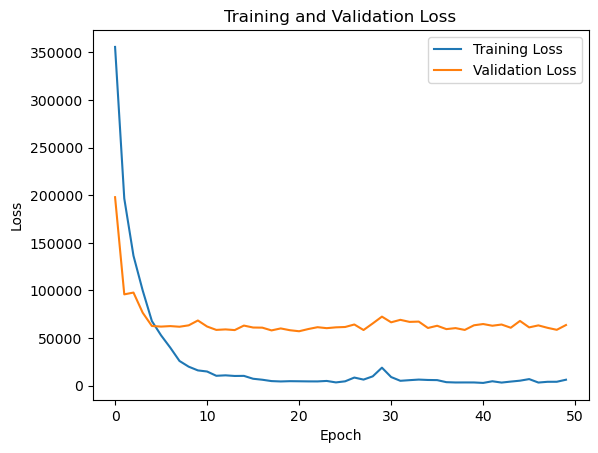

In [51]:
import matplotlib.pyplot as plt

num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device, epoch)
    val_loss = validate_model(model, val_loader, criterion, device, epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model1.pth')
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

# Plot the training history after training completes
history = {'loss': train_losses, 'val_loss': val_losses}
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Observations on the training and validation loss

- The histogram of training and validation losses over 50 epochs shows a decrease in loss over time, indicating that the model is learning and improving its performance. Initially, the losses are relatively high, but as the training progresses, they gradually decrease, indicating that the model is converging towards better solutions.

- Training Stops Improving after Ten Epochs:
After around 10 epochs, the improvement in both training and validation losses slows down significantly. While the training loss continues to decrease slightly, the validation loss starts to plateau or even increase slightly. This suggests that the model has learned most of what it can from the training data, and further training epochs might lead to overfitting or minimal performance gain on unseen data.

- Validation Loss vs. Training Loss:
Throughout the training process, the validation loss is consistently higher than the training loss. This is a common observation and indicates that the model is better at fitting the training data than generalizing to unseen validation data. It suggests that the model might be overfitting to the training data, as it performs better on the data it has seen compared to new, unseen data.

- Addressing this issue might involve techniques like regularization, data augmentation, or using more complex models that can better capture the underlying patterns in the data without overfitting.

# Model Evaluation (evaluate_model, visualize_predictions): 
Functions for evaluating the trained model on the test set and visualizing predictions are defined. The evaluate_model function computes the RMSE and MAE metrics on the test set, while the visualize_predictions function shows a comparison between actual and predicted crowd counts for a few images from the test set.

Test RMSE: 245.7244
Test MAE: 161.1769


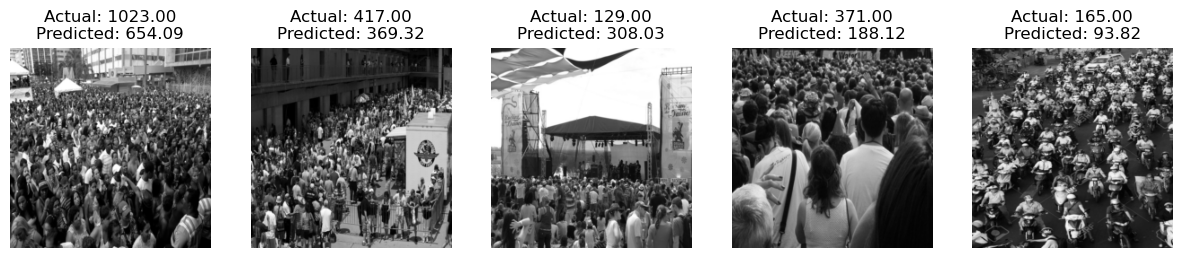

In [52]:
import math

def evaluate_model(model, test_loader, device):
    sum_squared_error = 0.0
    sum_absolute_error = 0.0
    total_samples = 0
    
    model.eval()
    model.load_state_dict(torch.load('best_model1.pth'))
    with torch.no_grad():
        for images, ages in test_loader:
            images, ages = images.to(device), ages.to(device)

            outputs = model(images)
            squared_errors = (outputs.view(-1) - ages) ** 2
            sum_squared_error += squared_errors.sum().item()

            absolute_errors = torch.abs(outputs.view(-1) - ages)
            sum_absolute_error += absolute_errors.sum().item()

            total_samples += ages.size(0)

    rmse = math.sqrt(sum_squared_error / total_samples)
    mae = sum_absolute_error / total_samples

    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE: {mae:.4f}')

def visualize_predictions(model, data_loader, device, num_images=5):
    model.eval()
    images, ages = next(iter(data_loader))
    images, ages = images.to(device), ages.to(device)
    with torch.no_grad():
        outputs = model(images)
    predictions = outputs.view(-1).cpu().numpy()
    actuals = ages.cpu().numpy()

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.title(f'Actual: {actuals[i]:.2f}\nPredicted: {predictions[i]:.2f}', color='black')
        plt.axis('off')
    plt.show()

evaluate_model(model, test_loader, device)
visualize_predictions(model, test_loader, device)


# Observations on the RMSE of model:
The test error is considerable. I know this because the actual versus predicted crowd count is far off by over 100 heads. This tells me this model would not be suitable to apply to a real world situation. Next I will try a more modern model using Vgg16 architechture on the same data and see if it performs better. 

In [53]:
import os
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import to_grayscale
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, Grayscale, ToTensor, Compose
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tensorboardX import SummaryWriter
import math

# Vgg16 Model (CrowdCounting):
This class defines a neural network model for predicting crowd counts using transfer learning from the vgg16 architecture. The forward method defines the forward pass of the network.

In [54]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CrowdCountingModel(nn.Module):
    def __init__(self):
        super(CrowdCountingModel, self).__init__()
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        # Freeze the weights of the layers obtained from the pre-trained model
        for param in vgg16.parameters():
            param.requires_grad = False
        
        # Define CovNet architecture
        self.features = vgg16.features
        
        # Replace the fully connected layers for crowd counting
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjust based on the dimensions of VGG16 features
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Set up the environment for training
Use an age prediction model on the CPU. It initializes the model, defines the Mean Squared Error loss function, and configures the Adam optimizer with a learning rate of 0.001.

In [55]:
import torch

device = torch.device("cpu")
print(device)
model2 = CrowdCountingModel().to(device)
print('Model instantiation done')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

cpu
Model instantiation done


# Training and Validation (train_model2, validate_model2):
Functions for training and validation are defined. The train_model function trains the model using the training data loader, while the validate_model function evaluates the model using the validation data loader.

In [56]:
def train_model2(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for inputs, counts in train_loader:
        inputs, counts = inputs.to(device), counts.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, counts.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)
    return avg_loss

def validate_model2(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, counts in val_loader:
            inputs, counts = inputs.to(device), counts.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, counts.view(-1, 1))
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss   


## Model 2 Training Loop:
The model is trained using a loop over multiple epochs. The training and validation losses are calculated for each epoch, and the best model based on validation loss is saved.



Epoch 1, Train Loss: 339386.7135416667, Val Loss: 152620.578125
Epoch 2, Train Loss: 126909.31293402778, Val Loss: 95312.8515625
Epoch 3, Train Loss: 84906.79644097222, Val Loss: 46110.0234375
Epoch 4, Train Loss: 38217.861219618055, Val Loss: 39719.49609375
Epoch 5, Train Loss: 21190.150553385418, Val Loss: 42623.69140625
Epoch 6, Train Loss: 13564.453640407986, Val Loss: 44170.0703125
Epoch 7, Train Loss: 7890.129503038194, Val Loss: 38824.5625
Epoch 8, Train Loss: 4746.3345133463545, Val Loss: 42365.75
Epoch 9, Train Loss: 1922.3734402126736, Val Loss: 38915.20703125
Epoch 10, Train Loss: 1747.4180094401042, Val Loss: 42442.9140625
Epoch 11, Train Loss: 1470.4638977050781, Val Loss: 41840.390625
Epoch 12, Train Loss: 817.6110161675347, Val Loss: 44080.12890625
Epoch 13, Train Loss: 558.0497148301866, Val Loss: 41096.80078125
Epoch 14, Train Loss: 559.5140821668837, Val Loss: 42166.90234375
Epoch 15, Train Loss: 643.388070848253, Val Loss: 43637.09765625
Epoch 16, Train Loss: 455.256

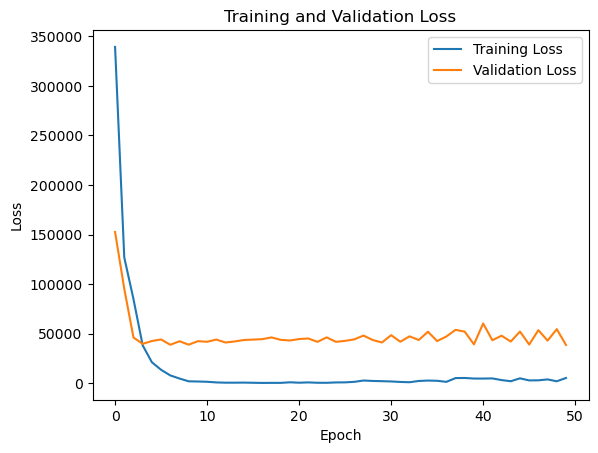

In [57]:
num_epochs = 50
train_losses_model2 = []
val_losses_model2 = []
best_val_loss_model2 = float('inf')

for epoch in range(num_epochs):
    train_loss_model2 = train_model2(model2, train_loader, criterion, optimizer, device, epoch)
    val_loss_model2 = validate_model2(model2, val_loader, criterion, device, epoch)
    train_losses_model2.append(train_loss_model2)
    val_losses_model2.append(val_loss_model2)
    
    if val_loss_model2 < best_val_loss_model2:
        best_val_loss_model2 = val_loss_model2
        torch.save(model2.state_dict(), 'best_model2.pth')
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss_model2}, Val Loss: {val_loss_model2}')

# Plot the training history after training completes
history = {'loss': train_losses_model2, 'val_loss': val_losses_model2}
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Observations on Training and Validation Loss
- The training and validation losses decrease initially but start to stabilize after around 10 epochs.
- Both losses continue to fluctuate throughout training, indicating that the model is learning but might not be converging to an optimal solution.
- The validation loss tends to be higher than the training loss, suggesting that the model might be overfitting to some extent.

# Model Evaluation (evaluate_model2, visualize_predictions2):
Functions for evaluating the trained model on the test set and visualizing predictions are defined. The evaluate_model function computes the RMSE and MAE metrics on the test set, while the visualize_predictions function shows a comparison between actual and predicted crowd counts for a few images from the test set

In [58]:
import torch
import math
import matplotlib.pyplot as plt

def evaluate_model2(model, test_loader, device):
    sum_squared_error = 0.0
    sum_absolute_error = 0.0
    total_samples = 0
    
    model.eval()
    model.load_state_dict(torch.load('best_model2.pth'))
    with torch.no_grad():
        for images, counts in test_loader:
            images, counts = images.to(device), counts.to(device)
            outputs = model(images)
            squared_errors = (outputs.view(-1) - counts) ** 2
            sum_squared_error += squared_errors.sum().item()
            absolute_errors = torch.abs(outputs.view(-1) - counts)
            sum_absolute_error += absolute_errors.sum().item()
            total_samples += counts.size(0)
    
    rmse = math.sqrt(sum_squared_error / total_samples)
    mae = sum_absolute_error / total_samples
    
    print(f'Test RMSE: {rmse:.4f}')
    print(f'Test MAE: {mae:.4f}')

def visualize_predictions2(model, test_loader, device, num_images=5):
    model.eval()
    images, counts = next(iter(test_loader))
    images, counts = images.to(device), counts.to(device)
    with torch.no_grad():
        outputs = model(images)
    predictions = outputs.view(-1).cpu().numpy()
    actuals = counts.cpu().numpy()

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.title(f'Actual: {actuals[i]:.2f}\nPredicted: {predictions[i]:.2f}', color='black')
        plt.axis('off')
    plt.show()


Test RMSE: 255.1410
Test MAE: 166.9721


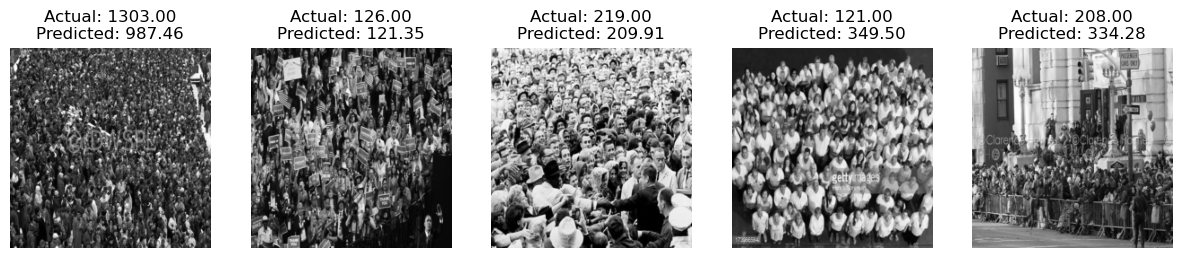

In [59]:
evaluate_model2(model2, test_loader, device)
visualize_predictions2(model2, test_loader, device)

# Observations on Model Evaluation

- The evaluation metrics on the test set show an RMSE (Root Mean Squared Error) of approximately 255.14 and an MAE (Mean Absolute Error) of approximately 166.97. These metrics indicate that, on average, the model's predictions deviate from the actual counts by around 255.14 individuals in terms of RMSE and approximately 166.97 individuals in terms of MAE.

### Improvement Opportunities:
- Possible avenues for improvement include fine-tuning hyperparameters, adjusting the model architecture, incorporating additional data augmentation techniques, or exploring more advanced crowd counting models.
- Regularization techniques could also be applied to mitigate overfitting and improve generalization to unseen data.
- Further analysis of mispredictions and error patterns could help identify specific areas where the model struggles and guide targeted improvements.

# Conclusion

In this project, the focus was on developing regression-based methods for crowd counting in densely populated areas, with a particular emphasis on detecting individual heads within crowds. Traditional manual counting methods are labor-intensive, time-consuming, and prone to errors, prompting the need for automated solutions.

The project began with data preparation, where text files containing image file names were created for training and validation sets. A custom dataset class was implemented for data loading and transformation, utilizing torchvision transforms for preprocessing. Two different deep learning models were explored: the Age Predictor Model based on AlexNet architecture and the Vgg16 Model (CrowdCounting) based on VGG16 architecture.

The training and validation loops were established for both models, with the Mean Squared Error (MSE) loss function used for optimization. Training histories were monitored, and the best-performing models were saved based on validation loss. Finally, the models were evaluated on the test set using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) metrics, and their predictions were visualized.

Comparing the two models, it's evident that the the Age Predictor Model based on AlexNet architecture outperformed the Vgg16-based CrowdCounting model. The Age Predictor model achieved a lower RMSE and MAE on the test set, indicating better precision in crowd counting. However, both models showed limitations, as evidenced by the relatively high errors in their predictions and their relatively quick plateau in learning in the epochs and the lack of precision of the predictions. The predicted head count is far enough off that neither model could be utilized in a real world setting. 

### To improve the models' performance, several strategies can be considered:

- Fine-tuning Hyperparameters: Experiment with different learning rates, optimizers, batch sizes, and epochs to find the optimal configuration for training.
- Model Architecture Adjustments: Explore more complex architectures or variations of existing ones specifically designed for crowd counting tasks.
- Data Augmentation: Apply additional data augmentation techniques such as random cropping, rotation, and flipping to increase the diversity of training samples.
- Regularization Techniques: Implement regularization methods like dropout or weight decay to prevent overfitting and improve generalization.
- Transfer Learning Variations: Experiment with different pre-trained models and transfer learning strategies to leverage features better suited for crowd counting.
- Error Analysis: Analyze mispredictions and error patterns to identify challenging scenarios or data biases and adjust the training approach accordingly.

Throughout the project, various edits were made to enhance model performance and accuracy, such as freezing the weights of pre-trained layers, transforming data to grayscale for better feature extraction, and utilizing appropriate data preprocessing techniques.

In summary, while both models show promise in automating crowd counting tasks, there is still room for improvement. By addressing the limitations and incorporating the suggested enhancements, future iterations of crowd counting models can strive for greater precision and reliability, ultimately contributing to more effective crowd management and safety practices in densely populated areas.